# JAL-AM

In [6]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from model_lib import *
from JAL_AM_lib import *

# Single run of JAL-AM

In [2]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500000, k)

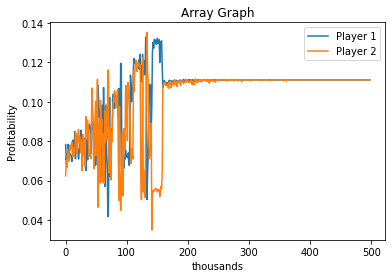

In [3]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

# n runs of JAL-AM

In [7]:
avg_prof,prof_gain,edge,focal= run_sim(100, np.linspace(0,1,7))

Q-learning: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


In [8]:
print("Edgeworth price cycles: ", edge)
print("Focal pricing: ", focal)

Edgeworth price cycles:  17
Focal pricing:  83


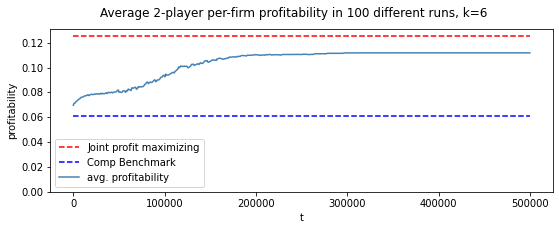

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(100, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [11]:
avg_prof[498]

0.11180458333333432

# Average profit gain

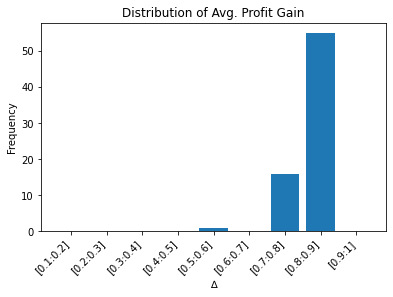

In [13]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

# Initialize an array to store counts for each interval
interval_counts = np.zeros(len(intervals), dtype=int)

# Iterate through the array and count values in each interval
for num in prof_gain:
    for i, interval in enumerate(intervals):
        if interval[0] <= num < interval[1]:
            interval_counts[i] += 1

# Plot the counts for each interval
plt.bar(np.arange(len(intervals)), interval_counts, tick_label=intervals_str)
plt.xticks(rotation=45, ha='right')
plt.xlabel('∆')
plt.ylabel('Frequency')
plt.title('Distribution of Avg. Profit Gain')
plt.subplots_adjust(top=0.925, 
                    bottom=0.20, 
                    left=0.1, 
                    right=0.90, 
                    hspace=0.01, 
                    wspace=0.01)
plt.savefig('Graphs/avg_prof_gain_jalam')
plt.show()

# Assymetric information

In [3]:
avg_prof_asym,prof_gain,n, firm1, firm2= run_sim_asym(100, np.linspace(0,1,7),0.5)

In [4]:
res, avg_prof_gain,t= run_sim(100, np.linspace(0,1,7))

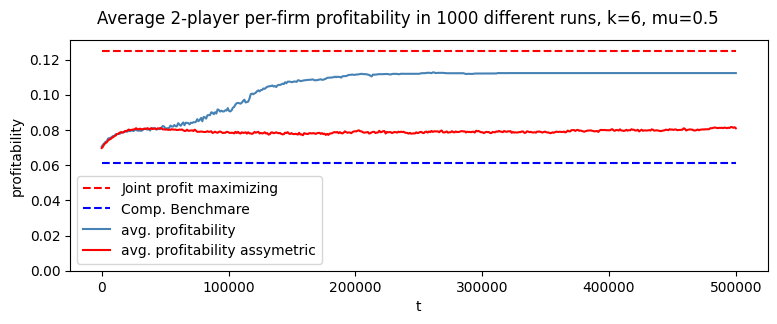

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}, mu={}".format(1000,6, 0.5))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp. Benchmare')#konstant taget fra johanne og morten
axs.plot(xs,res,color="steelblue", label ="avg. profitability")
axs.plot(xs, avg_prof_asym, color="red", label = "avg. profitability assymetric")

axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

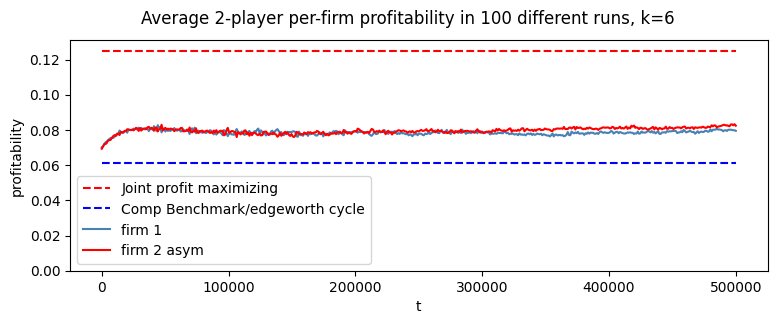

In [6]:
##
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark')
axs.plot(xs, firm1, color="steelblue", label = "firm 1")
axs.plot(xs, firm2, color="red", label = "firm 2 asym")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()